In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext

As soon as we will do most of the work on the cluster, here we will show how we deal with data on a small subsample (`data_min`)

In [2]:
# create the session
spark = SparkSession.builder.getOrCreate()

# create the context
sc = spark.sparkContext

In [3]:
from pyspark.sql.types import *

Load the data according to a schema and delete the columns we do not need:

In [4]:
schema = StructType([StructField('Country', StringType(), True),
                     StructField('Namespace', StringType(), True),
                     StructField('AirQualityNetwork', StringType(), True),
                     StructField('AirQualityStation', StringType(), True),
                     StructField('EoICode', StringType(), True),
                     StructField('SamplingPoint', StringType(), True),
                     StructField('SamplingProcess', StringType(), True),
                     StructField('Sample', StringType(), True),
                     StructField('Pollutant', StringType(), True),
                     StructField('AirPollutantCode', StringType(), True),
                     StructField('AveragingTime', StringType(), True),
                     StructField('Concentration', FloatType(), True),
                     StructField('Unit', StringType(), True),
                     StructField('DatetimeBegin', TimestampType(), True),
                     StructField('DatetimeEnd', TimestampType(), True),
                     StructField('Validity', IntegerType(), True),
                     StructField('Verification', IntegerType(), True)])

In [5]:
df = spark.read.format("com.databricks.spark.csv").option("inferSchema", "true") \
.option("timestampFormat", "yyyy-mm-dd hh:mm:ss XXX") \
.csv('./data_min/*/*', schema=schema, header=True) \
.drop("Namespace", "AirQualityStation", "AirQualityNetwork", "SamplingPoint", "SamplingProcess", "Sample", "AirPollutantCode")

Now the schema is the following:

| Field         | Type      | Description                                                    |
|---------------|-----------|----------------------------------------------------------------|
| Country       | String    | 2-letter country code                                          |
| EoICode       | String    | Unique station identifier                                      |
| Pollutant     | String    | Short name of pollutant                                        |
| AveragingTime | String    | Time for which the measurement has been taken (hour, day, etc) |
| Concentration | Float     | The measured value/concentration                               |
| Unit          | String    | Defines the unit of the concentration                          |
| DatetimeBegin | Timestamp | Start time (yyyy-mm-dd hh:mm:ss Z) of the measurement          |
| DatetimeEnd   | Timestamp | End time (yyyy-mm-dd hh:mm:ss Z) of the measurement            |
| Validity      | Integer   | The validity flag for the measurement                          |
| Verification  | Integer   | The verification flag for the measurement.                     |

In [8]:
df.show(10)

+-------+-------+---------+-------------+-------------+-----+-------------------+-------------------+--------+------------+
|Country|EoICode|Pollutant|AveragingTime|Concentration| Unit|      DatetimeBegin|        DatetimeEnd|Validity|Verification|
+-------+-------+---------+-------------+-------------+-----+-------------------+-------------------+--------+------------+
|     GB|GB0906A|       CO|         hour|     0.038925|mg/m3|2018-01-01 00:00:00|2018-01-01 01:00:00|       2|           1|
|     GB|GB0906A|       CO|         hour|     0.048175|mg/m3|2018-01-01 01:00:00|2018-01-01 02:00:00|       2|           1|
|     GB|GB0906A|       CO|         hour|     0.048175|mg/m3|2018-01-01 02:00:00|2018-01-01 03:00:00|       2|           1|
|     GB|GB0906A|       CO|         hour|     0.038911|mg/m3|2018-01-01 03:00:00|2018-01-01 04:00:00|       2|           1|
|     GB|GB0906A|       CO|         hour|     0.052807|mg/m3|2018-01-01 04:00:00|2018-01-01 05:00:00|       2|           1|
|     GB

*Validity* can take 5 different values:  
**-99** - Not valid due to station maintenance or calibration  
**-1** - Not valid  
**1** - Valid  
**2** - Valid, but below detection limit measurement value given  
**3** - Valid, but below detection limit and number replaced by 0.5 * detection_limit

*Verificaton* can take 3 different values:  
**1** - Verified  
**2** - Preliminary verified  
**3** - Not verified

Total number of lines:

In [9]:
df.count()

323784

We found one type of missing and incorrect values which is not covered by validity-verification pair: measurement value below zero.

In [14]:
df.select("*").where(df.Concentration < 0).show(5)

+-------+-------+---------+-------------+-------------+-----+-------------------+-------------------+--------+------------+
|Country|EoICode|Pollutant|AveragingTime|Concentration| Unit|      DatetimeBegin|        DatetimeEnd|Validity|Verification|
+-------+-------+---------+-------------+-------------+-----+-------------------+-------------------+--------+------------+
|     IE|IE0028A|      SO2|         hour|        -0.53|µg/m3|2018-01-24 08:00:00|2018-01-24 09:00:00|       1|           1|
|     IE|IE001CM|      SO2|         hour|       -0.266|µg/m3|2018-01-20 15:00:00|2018-01-20 16:00:00|       1|           1|
|     IE|IE001CM|      SO2|         hour|       -0.532|µg/m3|2018-01-20 16:00:00|2018-01-20 17:00:00|       1|           1|
|     IE|IE001CM|      SO2|         hour|       -0.266|µg/m3|2018-01-21 04:00:00|2018-01-21 05:00:00|       1|           1|
|     IE|IE001CM|      SO2|         hour|       -0.266|µg/m3|2018-01-16 15:00:00|2018-01-16 16:00:00|       1|           1|
+-------

Other inconsistencies, including `null` values are covered:

In [22]:
df.select("*").where(df.Concentration.isNull()).show(5)

+-------+-------+---------+-------------+-------------+-----+-------------------+-------------------+--------+------------+
|Country|EoICode|Pollutant|AveragingTime|Concentration| Unit|      DatetimeBegin|        DatetimeEnd|Validity|Verification|
+-------+-------+---------+-------------+-------------+-----+-------------------+-------------------+--------+------------+
|     GB|GB0906A|       CO|         hour|         null|mg/m3|2018-01-19 15:00:00|2018-01-19 16:00:00|      -1|           1|
|     GB|GB0906A|       CO|         hour|         null|mg/m3|2018-01-19 16:00:00|2018-01-19 17:00:00|      -1|           1|
|     GB|GB0906A|       CO|         hour|         null|mg/m3|2018-01-06 15:00:00|2018-01-06 16:00:00|      -1|           1|
|     GB|GB0906A|       CO|         hour|         null|mg/m3|2018-01-06 16:00:00|2018-01-06 17:00:00|      -1|           1|
|     GB|GB0906A|       CO|         hour|         null|mg/m3|2018-01-07 11:00:00|2018-01-07 00:00:00|      -1|           1|
+-------

So, we have to filter those values in each query.

Also, we have files containing all the information about the stations and the areas of European countries:

In [4]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from os.path import isfile, join, isdir

RELATIVE_DATA_PATH = './data'
# Load metadata
metadata = pd.read_csv(join(RELATIVE_DATA_PATH, 'metadata.csv'))
# Load file containing the areas of the EU countries:
area = pd.read_csv('area.csv')

`metadata.csv` has the following structure

| Field                    | Type    | Description                                                                                                               |
|--------------------------|---------|---------------------------------------------------------------------------------------------------------------------------|
| Countrycode              | String  | Country iso code                                                                                                          |
| Namespace                | String  | Namespace of network                                                                                                      |
| AirQualityNetwork        | String  | Network identifier                                                                                                        |
| AirQualityStation        | String  | Localid of station                                                                                                        |
| AirQualityNatCode        | String  | National code of station                                                                                                  |
| AirQualityStationEoICode | String  | Station EoI code as used in the past AirBase system                                                                       |
| AirQualityStationArea    | String  | Reference to area code. Full list at http://dd.eionet.europa.eu/vocabulary/aq/areaclassification/view                     |
| SamplingPoint            | String  | Localid of samplingpoint                                                                                                  |
| SamplingProcess          | String  | Localid of process                                                                                                        |
| Sample                   | String  | Localid of sample (also known as feature of interest)                                                                     |
| BuildingDistance         | Integer | Distance to building (m). Value of -999 indicate unknown                                                                  |
| EquivalenceDemonstrated  | String  | Reference to demonstrated equivalence. Full list at http://dd.eionet.europa.eu/vocabulary/aq/equivalencedemonstrated/view |
| InLetHeight              | Integer | Height of inlet (m). Value of -999 indicate unknown                                                                       |
| KerpDistance             | Integer | Distance to kerp (m). Value of -999 indicate unknown                                                                      |
| MeasurementEquipment     | String  | Refernce (URL) to measurement equipment                                                                                   |
| MeasurementType          | String  | Reference to measurement type (full list at http://dd.eionet.europa.eu/vocabulary/aq/measurementtype/view)                |
| MeasurementMethod        | String  | Reference to measurement method (full list at http://dd.eionet.europa.eu/vocabulary/aq/measurementmethod/view)            |
| AirPollutantCode         | String  | Reference (URL) to pollutant definition in data dictionary                                                                |
| AirPollutant             | String  | Short pollutant name measured at this samplingpoint                                                                       |
| AirQualityStationType    | String  | Short name of station type (full list at http://dd.eionet.europa.eu/vocabulary/aq/stationclassification/view)             |
| Projection               | String  | Reference to projection                                                                                                   |
| Longitude                | Decimal | Longitude of samplingpoint                                                                                                |
| Latitude                 | Decimal | Latitude of samplingpoint                                                                                                 |
| Altitude                 | Integer | Altitude of samplingpoint (m)  

Some columns in `metadata` contain missing values but we do not need them, so no additional preprocessing is required.

In [5]:
metadata.sample(5)

,Countrycode,Namespace,AirQualityNetwork,AirQualityStation,AirQualityStationNatCode,AirQualityStationEoICode,AirQualityStationArea,SamplingPoint,SamplingProcess,Sample,...,MeasurementEquipment,MeasurementType,MeasurementMethod,AirPollutantCode,AirPollutant,AirQualityStationType,Projection,Longitude,Latitude,Altitude
47219,PL,PL.CIEP.AQ,NET_PL_LD_AQ,STA_PL0510A,LdPioTrSienk,PL0510A,urban,SPO_PL0510A_6001_001,SPP_PL0510A_6001_001,SAM_PL0510A_6001_001,...,NaN,active,NaN,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,PM2.5,background,EPSG:4979,19.688694,51.407844,198.0
29771,FR,FR.LCSQA-INERIS.AQ,NET-FR035A,STA-FR23124,FR23124,FR23124,rural-remote,SPO-FR23124_00005_100,SPP-FR_A_TEOM_D9099,SPO_F-FR23124_00005_100_100,...,NaN,automatic,http://dd.eionet.europa.eu/vocabulary/aq/measu...,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,PM10,background,EPSG:4979,-0.743681,46.656683,100.0
30198,FR,FR.LCSQA-INERIS.AQ,NET-FR069A,STA-FR25036,FR25036,FR25036,urban,SPO-FR25036_00007_100,SPP-FR_A_UV-P_D9045,SPO_F-FR25036_00007_100_100,...,NaN,automatic,http://dd.eionet.europa.eu/vocabulary/aq/measu...,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,O3,background,EPSG:4979,1.093694,49.442458,17.0
11994,DE,http://gdi.uba.de/arcgis/rest/services/inspire...,NET.DE_BW,STA.DE_DEBW126,DEBW126,DEBW126,urban,SPO.DE_DEBW126_NO2_dataGroup3,SPP.DE_DEBW126_NO2_passive_passiveadsorbant_IC...,SAM.DE_DEBW126_1,...,NaN,passive,NaN,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,NO2,traffic,EPSG:4979,8.369270,49.005360,117.0
49577,RO,RO.ANPM.AQ,NET-RO017A,STA-RO0077A,CLU5,RO0077A,urban,SPO-RO0077A_00007_100,SPP-RO_A_UV-P_01098,SPO_F-RO0077A_00007_100_100,...,http://dd.eionet.europa.eu/vocabulary/aq/measu...,automatic,http://dd.eionet.europa.eu/vocabulary/aq/measu...,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,O3,background,EPSG:4979,23.877501,47.153889,279.0


We began our analysis with calculation station densities per km2 and plotting them on the map.

In [12]:
# calculate the densities (stations per 1000 km2)
stations_per_country = metadata.groupby('Countrycode').AirQualityStationEoICode.nunique()
stations_per_area = area.join(stations_per_country, on='Countrycode')
stations_per_area['density'] = stations_per_area['AirQualityStationEoICode'] * 1000 / stations_per_area['Area']
stations_per_area.sample(5)

,name,Countrycode,Area,AirQualityStationEoICode,density
32,Portugal,PT,92226.0,69,0.748162
27,Macedonia,MK,25333.0,26,1.026329
20,Ireland,IE,69797.0,35,0.501454
9,Germany,DE,357376.0,731,2.045465
37,Slovakia,SK,49035.0,38,0.774957


In [7]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes
import math

In [9]:
import geoplot
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)

Query the european countries:

In [18]:
europe = world.query('continent == "Europe" or name == "Turkey" or name=="Cyprus"')
europe.sample(5)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
21,5320045,Europe,Norway,-99,364700.0,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."
170,3856181,Europe,Bosnia and Herz.,BIH,42530.0,"POLYGON ((18.56000 42.65000, 17.67492 43.02856..."
150,1972126,Europe,Slovenia,SVN,68350.0,"POLYGON ((13.80648 46.50931, 14.63247 46.43182..."
131,10839514,Europe,Portugal,PRT,297100.0,"POLYGON ((-9.03482 41.88057, -8.67195 42.13469..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."


Now perform an inner join with `stations_per_area` and convert to a GeoDF:

In [19]:
europe_merged = europe.merge(stations_per_area, on='name', how='inner')
europe_merged.sample(5)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Countrycode,Area,AirQualityStationEoICode,density
6,21529967,Europe,Romania,ROU,441000.0,"POLYGON ((28.23355 45.48828, 28.67978 45.30403...",RO,238397.0,146,0.612424
25,64769452,Europe,United Kingdom,GBR,2788000.0,"MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...",GB,248536.0,233,0.937490
21,48958159,Europe,Spain,ESP,1690000.0,"POLYGON ((-7.45373 37.09779, -7.53711 37.42890...",ES,505944.0,651,1.286704
26,339747,Europe,Iceland,ISL,16150.0,"POLYGON ((-14.50870 66.45589, -14.73964 65.808...",IS,102775.0,37,0.360010
4,8754413,Europe,Austria,AUT,416600.0,"POLYGON ((16.97967 48.12350, 16.90375 47.71487...",AT,83879.0,199,2.372465


In [20]:
europe_geo = gpd.GeoDataFrame(europe_merged, geometry='geometry')

In [25]:
import matplotlib.colors as colors

(25, 75)

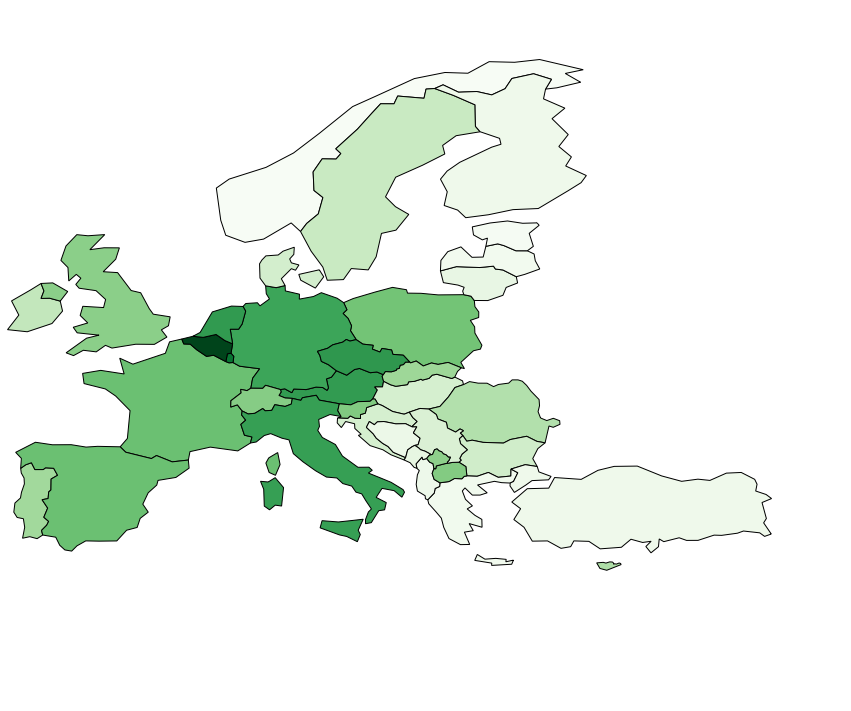

In [39]:
europe_plot = geoplot.choropleth(
    europe_geo, hue=europe_geo['density'],
    norm=colors.LogNorm(europe_geo['density'].min(), vmax=europe_geo['density'].max()),
    cmap='Greens', figsize=(15, 15)
)
europe_plot.set_xlim(-10, 50)
europe_plot.set_ylim(25, 75)

For future, we plan to make these maps interactive and more precise.